In [1]:
import sys
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from ipywidgets import IntProgress
from IPython.display import display

## Set Parameter
$L1, L2$ are two rods length

$m1, m2$ are two bobs mass

In [2]:
L1, L2 = 1, 1
m1, m2 = 1, 2
g = 9.81

## Build up the forluma of Z

Follow the Forluma by Understanding & Dicovery 

\begin{align*}
\dot{z}_1 = \frac{m_2g\sin\theta_2\cos(\theta_1-\theta_2) - m_2\sin(\theta_1 - \theta_2)[l_1z_1^2\cos(\theta_1 - \theta_2) + l_2z_2^2] - (m_1+m_2)g\sin\theta_1}{l_1[m_1 + m_2\sin^2(\theta_1-\theta_2)]},\\
\dot{z}_2 = \frac{(m_1+m_2)[l_1z_1^2\sin(\theta_1-\theta_2) - g\sin\theta_2 + g\sin\theta_1\cos(\theta_1-\theta_2)]+m_2l_2z_2^2\sin(\theta_1-\theta_2)\cos(\theta_1-\theta_2)}{l_2[m_1 + m_2\sin^2(\theta_1-\theta_2)]}
\end{align*}


In [3]:
def deriv(y, t, L1, L2, m1, m2):
    """Return the first derivatives of y = theta1, z1, theta2, z2."""
    theta1, z1, theta2, z2 = y

    c, s = np.cos(theta1-theta2), np.sin(theta1-theta2)

    theta1dot = z1
    z1dot = (m2*g*np.sin(theta2)*c - m2*s*(L1*z1**2*c + L2*z2**2) -
             (m1+m2)*g*np.sin(theta1)) / L1 / (m1 + m2*s**2)

    theta2dot = z2
    z2dot = ((m1+m2)*(L1*z1**2*s - g*np.sin(theta2) + g*np.sin(theta1)*c) + 
             m2*L2*z2**2*s*c) / L2 / (m1 + m2*s**2)
             
    return theta1dot, z1dot, theta2dot, z2dot

## Follow Lagrange Equation
Calculus the total energy of the system.
\begin{align*}
\frac{\mathrm{d}}{\mathrm{d}t}\left(\frac{\partial\mathcal{L}}{\partial \dot{q}_i}\right) - \frac{\partial \mathcal{L}}{\partial q_i} = 0 \quad \mathrm{for}\;q_i = \theta_1, \theta_2.
\end{align*}
\begin{align*}
V &= m_1gy_1 + m_2gy_2 = -(m_1 + m_2)l_1g\cos\theta_1 - m_2l_2g\cos\theta_2\\
T 
&= \tfrac{1}{2}m_1l_1^2\dot{\theta}_1^2 + \tfrac{1}{2}m_2[l_1^2\dot{\theta}_1^2 + l_2^2\dot{\theta}_2^2 + 2l_1l_2\dot{\theta}_1\dot{\theta}_2\cos(\theta_1 - \theta_2)]
\end{align*}

\begin{align*}
\mathcal{L} =  \tfrac{1}{2}(m_1+m_2)l_1^2\dot{\theta}_1^2 + \tfrac{1}{2}m_2l_2^2\dot{\theta}_2^2 + m_1l_1l_2\dot{\theta}_1\dot{\theta}_2\cos(\theta_1 - \theta_2) + (m_1+m_2)l_1g\cos\theta_1 + m_2gl_2\cos\theta_2.
\end{align*}


In [4]:
def calc_E(y):
    th1, th1d, th2, th2d = y.T
    V = -(m1+m2)*L1*g*np.cos(th1) - m2*L2*g*np.cos(th2)
    T = 0.5*m1*(L1*th1d)**2 + 0.5*m2*((L1*th1d)**2 + (L2*th2d)**2 +
            2*L1*L2*th1d*th2d*np.cos(th1-th2))
    return T + V

## Build up ans Solve the Equation

In [5]:
tmax, dt = 30, 0.01
t = np.arange(0, tmax+dt, dt)

y0 = np.array([0*np.pi/7, 0, 3*np.pi/12, 0])
y = odeint(deriv, y0, t, args=(L1, L2, m1, m2))

## Throw The Error if energy drift too large

In [7]:
EDRIFT = 0.05
E = calc_E(y0)
if np.max(np.sum(np.abs(calc_E(y) - E))) > EDRIFT:
    sys.exit('Maximum energy drift of {} exceeded.'.format(EDRIFT))

In [8]:
theta1, theta2 = y[:,0], y[:,2]
x1 = L1 * np.sin(theta1)
y1 = -L1 * np.cos(theta1)
x2 = x1 + L2 * np.sin(theta2)
y2 = y1 - L2 * np.cos(theta2)

In [10]:
r = 0.05
# Plot a trail of the m2 bob's position for the last trail_secs seconds.
trail_secs = 1
max_trail = int(trail_secs / dt)

## Make the Graph in Time i

In [11]:
def make_plot(i):
    ax.plot([0, x1[i], x2[i]], [0, y1[i], y2[i]], lw=2, c='k')
    c0 = Circle((0, 0), r/2, fc='k', zorder=10)
    c1 = Circle((x1[i], y1[i]), r, fc='b', ec='b', zorder=10)
    c2 = Circle((x2[i], y2[i]), r, fc='r', ec='r', zorder=10)
    
    ax.add_patch(c0)
    ax.add_patch(c1)
    ax.add_patch(c2)

    # The trail will be divided into ns segments and plotted as a fading line.
    ns = 20
    s = max_trail // ns

    for j in range(ns):
        imin = i - (ns-j)*s
        if imin < 0:
            continue
        imax = imin + s + 1
        # The fading looks better if we square the fractional length along the trail.
        alpha = (j/ns)**2
        ax.plot(x2[imin:imax], y2[imin:imax], c='r', solid_capstyle='butt',
                lw=2, alpha=alpha)

    # Centre the image on the fixed anchor point, and ensure the axes are equal
    ax.set_xlim(-L1-L2-r, L1+L2+r)
    ax.set_ylim(-L1-L2-r, L1+L2+r)
    ax.set_aspect('equal', adjustable='box')
    plt.axis('off')
    plt.savefig('frames/img{:03d}.png'.format(i//di), dpi=72)
    plt.cla()

## Do simulation
Frames per second

IntProgress(value=0)

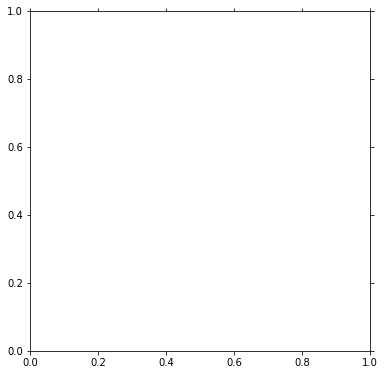

In [26]:
fps = 10
di = int(1/fps/dt)
fig = plt.figure(figsize=(8.3333, 6.25), dpi=72)
ax = fig.add_subplot(111)
p = IntProgress()
display(p)

for i in range(0, t.size, di):
    p.value = (i/t.size)*100+1
    make_plot(i)

## Merge png to MP4

In [13]:
!ffmpeg -r 20 -i frames/img%03d.png -c:v libx264 out2.mp4

ffmpeg version 4.2.4-1ubuntu0.1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.3.0-10ubuntu2)
  configuration: --prefix=/usr --extra-version=1ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-l